In [1]:
import sys
sys.path.append('../../')

import numpy as np

from helper import *

In [2]:
from scipy.optimize import line_search
from collections import deque

def lbfgs(initial_w, func, grad_func, max_iter=1000, m=10, tolerance=1e-20, eps=1e-10):
    result = [np.copy(initial_w)]
    current_x = np.copy(initial_w)
    n = len(initial_w)
    H = 1

    y = deque(maxlen=m)
    s = deque(maxlen=m)
    rho = deque(maxlen=m)

    for i in range(max_iter):

        if abs(func(current_x)) < tolerance:
            break

        q = grad_func(current_x)

        alpha = np.zeros(m)

        if i > m:
            for i in reversed(range(len(y))):
                alpha[i] = rho[i] * s[i].T @ q
                q = q - alpha[i] * y[i]

        r = H * q

        if i > m:
            for i in range(len(y)):
                beta = rho[i] * y[i].T @ r
                r = r + s[i] * (alpha[i] - beta)

        p = -r

        # Wolfe
        a, _, _, _, _, _ = line_search(func, grad_func, current_x, p, amax=100)

        if a is None:
            a = 1e-2

        new_x = current_x + a * p

        # if np.linalg.norm(new_x - current_x, 2) < tolerance:
        #     print("too small")
        #     break


        s.append(new_x - current_x)
        y.append(grad_func(new_x) - q)
        rho.append(1 / (y[-1].T @ s[-1] + eps))

        H = s[-1].T @ y[-1] / (y[-1].T @ y[-1])

        current_x = new_x
        result.append(current_x)

    return result

In [3]:
class minibatch_lbfgs:
    def mse_loss(self, x):
        y_pred = np.dot(self.X, x[0])
        mse = np.mean((self.y - y_pred) ** 2)
        return mse

    def mse_loss_grad(self, x):
        # Choose n random data points from the training set without replacement
        indices = np.random.choice(self.X.shape[0], self.batch_size, replace=False)
        X_batch = self.X[indices, :]
        y_batch = self.y[indices]

        # Compute the gradient of the MSE loss with respect to x for the chosen data points
        y_pred = np.dot(X_batch, x)
        grad = 2 * np.dot(X_batch.T, (y_pred - y_batch))

        # Sum values in rows of grad and divide by n
        grad_mean = np.sum(grad, axis=1) / self.batch_size

        return grad_mean
    
    def __init__(self, X, y, batch_size=2, method='mse'):
        self.X = X
        self.y = y
        self.batch_size = batch_size

        if self.batch_size > X.shape[0]:
            self.batch_size = X.shape[0]

        if method == 'mse':
            self.f = self.mse_loss 
            self.grad = self.mse_loss_grad
        else:
            print('method not found')
        

    def constant_lr_scheduling(epoch, initial_lr):
        return initial_lr

    def gradient_descent(self, x0, max_epochs=1000, eps=1e-5):
        return lbfgs(x0, self.f, self.grad, tolerance=eps, max_iter=max_epochs)

    def get_loss_history(self, results):
        loss_history = []

        for i in range(len(results)):
            loss_history.append(self.f(results[i]))

        return loss_history
    


In [4]:
from tqdm import tqdm

def research_minibatch_calculation(n_tests=1):
    results = []

    real_weight, real_bias = 2, 0

    dots_count = 500
    variance = 0.5
    X = np.random.rand(dots_count, 1)
    y = real_weight * X + real_bias + (np.random.rand(dots_count, 1) * variance - variance / 2)
    loss_real = minibatch_lbfgs(X, y).get_loss_history([[real_weight]])[-1]

    for i in tqdm(range(1, X.shape[0] + 1)):
        count_sum = 0
        for j in range(n_tests):
            sgd = minibatch_lbfgs(X, y, batch_size=i)
            loss_real = sgd.get_loss_history([[real_weight]])[-1]
            result = sgd.gradient_descent(np.array([0], float), max_epochs=15, eps=loss_real*2)
            count_sum += len(result)
        results.append(count_sum / n_tests)
        
        # print(results[-1])
        if results[-1] > 500:
            break
    
    return results

In [5]:
def research_minibatch_view(results, start=None, end=None, name_fig=''):
    if start is None:
        start = 1
    if end is None:
        end = len(results)

    # График n_epochs
    plt.plot(range(start, end+1), results[start-1:end], label='Minibatch GD L-BFGS', antialiased=True, linewidth=2)
    plt.xlabel('Batch size')
    plt.ylabel('n epochs')
    plt.legend()

    if name_fig != '':
        plt.savefig(name_fig, dpi=512, bbox_inches=0, transparent=True)

    plt.show()

plt.style.use('default')
_ = plt.figure(figsize=(8, 8))

<Figure size 800x800 with 0 Axes>

In [6]:
results = research_minibatch_calculation(n_tests=10)

  0%|          | 0/500 [00:00<?, ?it/s]c:\Users\My\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\Users\My\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: The line search algorithm could not find a solution less than or equal to amax: 100
  warn(msg, LineSearchWarning)
C:\Users\My\AppData\Local\Temp\ipykernel_12584\4107632952.py:54: RuntimeWarning: invalid value encountered in scalar divide
  H = s[-1].T @ y[-1] / (y[-1].T @ y[-1])
100%|██████████| 500/500 [03:35<00:00,  2.32it/s]


In [7]:
print(results)

[11.9, 6.4, 9.1, 14.6, 13.5, 6.4, 10.6, 13.2, 9.1, 6.2, 10.4, 13.2, 11.8, 14.6, 14.7, 10.7, 14.7, 9.1, 6.4, 3.9, 7.8, 7.7, 7.7, 12.0, 7.6, 10.4, 11.8, 11.8, 14.7, 16.0, 14.6, 16.0, 16.0, 16.0, 16.0, 14.7, 16.0, 16.0, 14.6, 14.7, 13.3, 13.2, 11.9, 11.8, 11.8, 6.5, 9.0, 7.6, 3.4, 3.5, 3.4, 6.2, 3.4, 4.9, 3.4, 2.0, 2.0, 3.4, 4.8, 3.4, 9.0, 10.4, 7.6, 11.8, 13.2, 14.6, 11.8, 16.0, 14.6, 14.6, 16.0, 16.0, 16.0, 16.0, 14.6, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 14.7, 14.7, 14.7, 13.3, 16.0, 14.7, 16.0, 16.0, 14.7, 16.0, 14.7, 13.4, 13.3, 10.6, 11.8, 13.2, 12.0, 7.8, 7.7, 7.7, 9.2, 7.6, 4.8, 6.2, 4.8, 3.4, 2.1, 3.4, 2.0, 3.4, 2.0, 3.4, 2.0, 3.4, 2.0, 2.0, 2.0, 2.0, 3.4, 2.0, 2.0, 2.0, 2.0, 2.0, 4.8, 4.8, 3.4, 4.8, 4.8, 4.8, 7.6, 9.0, 6.2, 6.2, 6.2, 13.2, 14.6, 13.2, 13.2, 13.2, 14.6, 14.6, 16.0, 16.0, 14.6, 14.6, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0

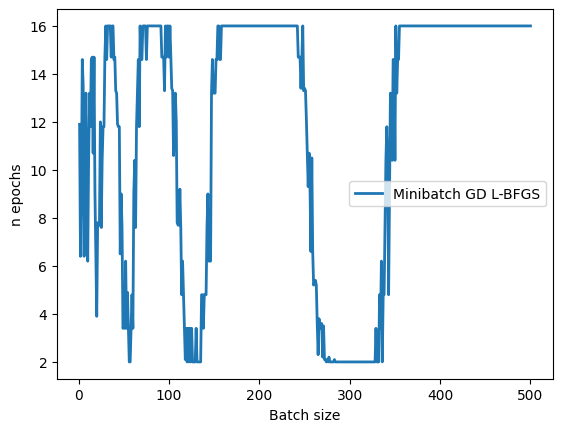

In [8]:
research_minibatch_view(results, name_fig='L-BFGS_all')

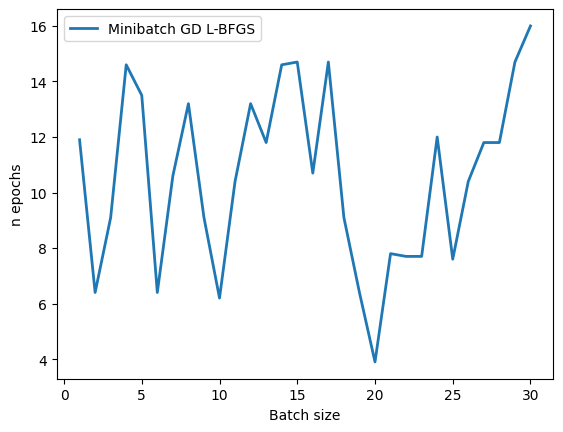

In [9]:
research_minibatch_view(results, 1, 30, name_fig='L-BFGS_1_10')

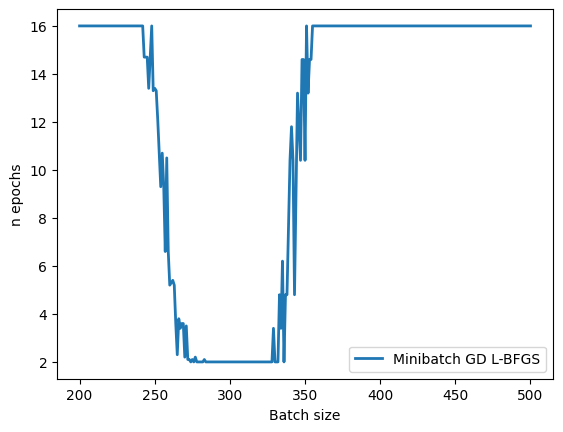

In [10]:
research_minibatch_view(results, 200, 500, name_fig='L-BFGS_200_500')